In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import MinMaxScaler 

from keras.metrics import MeanSquaredError
from keras.models import Sequential 
from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers.legacy import SGD

In [22]:
data_amex  = pd.read_csv('./dataset/amex_data.csv')
data_nsdq = pd.read_csv('./dataset/nasdaq_data.csv')
data_nyse = pd.read_csv('./dataset/nyse_data.csv')
data = pd.concat([data_amex, data_nsdq, data_nyse])
data = data.drop(columns=['Unnamed: 0'])
data['Date'] = pd.to_datetime(data['Date'])

In [23]:
data_amzn = data[data['symbol'] == 'AMZN']
data_amzn.head()

,Date,symbol,Open,High,Low,Close,Adj Close,Volume
633252,1997-05-15,AMZN,0.12187,0.12500,0.09635,0.09792,0.09792,1443120000.00000
633253,1997-05-16,AMZN,0.09844,0.09896,0.08542,0.08646,0.08646,294000000.00000
633254,1997-05-19,AMZN,0.08802,0.08854,0.08125,0.08542,0.08542,122136000.00000
633255,1997-05-20,AMZN,0.08646,0.08750,0.08177,0.08177,0.08177,109344000.00000
633256,1997-05-21,AMZN,0.08177,0.08229,0.06875,0.07135,0.07135,377064000.00000


In [24]:
df = data_amzn.set_index('Date').sort_index()
df = df[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)
df.head()

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
1997-05-15,0.10000,0.12000,0.12000,0.10000,0.10000,1443120000.00000
1997-05-16,0.09000,0.10000,0.10000,0.09000,0.09000,294000000.00000
1997-05-19,0.09000,0.09000,0.09000,0.08000,0.09000,122136000.00000
1997-05-20,0.08000,0.09000,0.09000,0.08000,0.08000,109344000.00000
1997-05-21,0.07000,0.08000,0.08000,0.07000,0.07000,377064000.00000


In [25]:
df_18 = df[df.index.year == 2018]
df_18.head()

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2018-01-02,59.45000,58.60000,59.50000,58.53000,59.45000,53890000.00000
2018-01-03,60.21000,59.42000,60.27000,59.42000,60.21000,62176000.00000
2018-01-04,60.48000,60.25000,60.79000,60.23000,60.48000,60442000.00000
2018-01-05,61.46000,60.88000,61.46000,60.50000,61.46000,70894000.00000
2018-01-08,62.34000,61.80000,62.65000,61.60000,62.34000,85590000.00000


In [26]:
df_19 = df[df.index.year == 2019]
df_19.head()

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2019-01-02,76.96000,73.26000,77.67000,73.05000,76.96000,159662000.00000
2019-01-03,75.01000,76.00000,76.90000,74.86000,75.01000,139512000.00000
2019-01-04,78.77000,76.50000,79.70000,75.92000,78.77000,183652000.00000
2019-01-07,81.48000,80.12000,81.73000,79.46000,81.48000,159864000.00000
2019-01-08,82.83000,83.23000,83.83000,80.83000,82.83000,177628000.00000


In [27]:
def ts_train_test_normalize(train_data, test_data, time_steps, for_periods):
    """
    입력: 
        train_data: 훈련 데이터
        test_data: 테스트 데이터
    출력: 
        X_train, y_train: 훈련 데이터
        X_test : 테스트 데이터
        sc : 훈련 데이터에 맞게 인스턴스화된 MinMaxScaler 객체
    """
    # 훈련 및 테스트 데이터를 값으로 변환
    ts_train = train_data.iloc[:,0:1].values
    ts_test = test_data.iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # 데이터 스케일링
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # s 샘플과 t 타임 스텝의 훈련 데이터 생성
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # 효율적인 모델링을 위한 X_train 재구성
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # 입력 데이터 준비
    inputs = np.concatenate((ts_train, ts_test), axis=0)
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # X_test 준비
    X_test = []
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train, X_test, sc

In [28]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df_18, df_19, 5, 2)

In [29]:
def GRU_model(X_train, y_train, X_test, sc):
    
        
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, 
                                         decay = 1e-7, 
                                         momentum = 0.9, 
                                         nesterov = False), 
                         loss = 'mean_squared_error')
    
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, 
                     y_train, 
                     epochs = 50, 
                     batch_size = 150, 
                     verbose = 1)
    
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    
    return my_GRU_model, GRU_prediction 

In [30]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)

Epoch 1/50


/Users/b06/miniforge3/envs/yeardream/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 2s 11ms/step - loss: 0.3634
Epoch 2/50
2/2 [==============================] - 0s 9ms/step - loss: 0.2440
Epoch 3/50
2/2 [==============================] - 0s 10ms/step - loss: 0.1094
Epoch 4/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0445
Epoch 5/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0590
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0999
Epoch 7/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1135
Epoch 8/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0898
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 10/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0364
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 12/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0418
Epoch 13/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0465
Epoc

In [31]:
def actual_pred_plot(preds):
    """
    실제 값과 예측 값을 그래프로 그립니다.
    """
    actual_pred = pd.DataFrame(columns = ['Adj Close', 'prediction'])  # DataFrame 생성
    actual_pred['Adj Close'] = df_19['Adj Close'][0:len(preds)]  # 실제 값
    actual_pred['prediction'] = preds[:,0]  # 예측 값
    
    
    m = MeanSquaredError()  # MeanSquaredError 인스턴스 생성
    m.update_state(np.array(actual_pred['Adj Close']), np.array(actual_pred['prediction']))  # 상태 업데이트
    
    
    return (m.result().numpy(), actual_pred.plot())  # Mean Squared Error와 그래프 반환

In [32]:
def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

(5.6745462, <Axes: xlabel='Date'>)

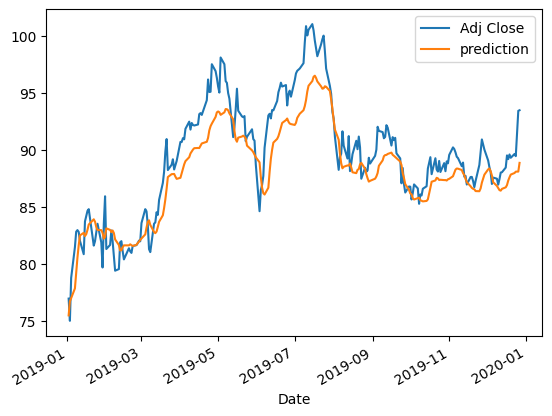

In [33]:
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [34]:
# 예측값을 데이터 프레임으로 변환
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0], columns=['Predicted Adj. Close'])

# 테스트 데이터 (실제 값) 준비
y_test_gru = df_19['Adj Close'][0:len(GRU_prediction)].reset_index(drop=True)

In [35]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,1.93746
RMSE,2.38213
RMSLE,0.02587
R2,0.77916


In [36]:
# 예측값을 데이터 프레임으로 변환
predicted_df = pd.DataFrame(GRU_prediction, columns=['Predicted Adj. Close', 'Another Column'])

# 데이터 프레임을 CSV 파일로 저장
predicted_df.to_csv('./pred/GRU_predictions.csv', index=False)